# Un-Cubemapping Data

Having cubemapped data is useful if, for instance, you want to look at a specific area on the sky. This lends well to looking at a single galaxy, or a single galaxy cluster that fit entirely within one of the six faces of the cubemapped sky. However, to look at the universe as whole, it can be easier to have *all* of the data within a unified coordinate system. Maybe the easiest transformation is that from a cubemap coordinate system (e.g. Front face, X/Y coordinates) to an equirectangular coordinate system (one image, X/Y coordinates). 

With that in mind, let's get started by defining the location of our data. 

In [1]:
datapath = 'Sim Data (Clusters; 800, Seed; 2639)' # all of the data is within a folder in this .ipynb file's directory

### Cubemapped Data

In the codeblock below, I've stitched together the 6 cube face images to show how they align with each other. In the middle row, our faces are (in order): Left, Front, Right, Back.

We can see that the bottom of the Top image fits onto the top of the Left image, and the top of the Bottom image fits onto the bottom of the Left image. 

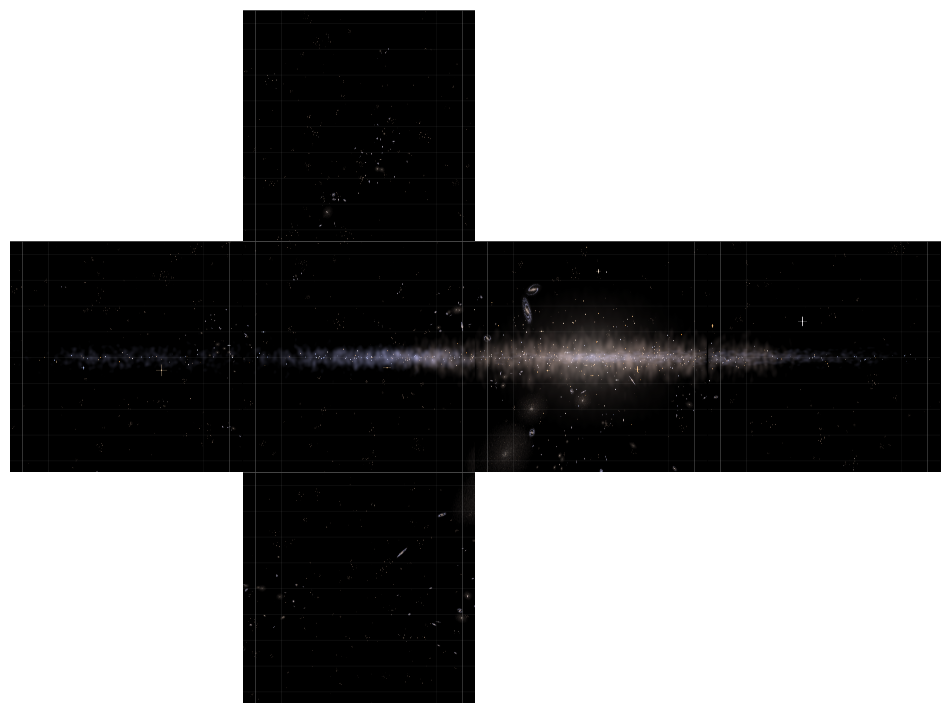

In [52]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig, axes = plt.subplots(3, 4, figsize=(12, 9)) # generate a figure to fit 3 high by 4 wide square images
fig.subplots_adjust(wspace=0, hspace=0) # we want these squares to be adjacent to each other, with no gap
# now to iterate over each subplot and remove the axis bars and ticks/labels
for row in axes:
    for ax in row:
        for side in ['top','right','bottom','left']:
            ax.spines[side].set_visible(False)
        ax.tick_params(axis='both', which='both', labelbottom=False, bottom=False, left=False, labelleft=False)

# now we load in the images and put them at their correct location
for i, direct in enumerate(["Back", "Left", "Front", "Right", "Top", "Bottom"]): # one loop for each direction
    img = mpimg.imread(datapath + f'/{direct}/{direct}.png') # this loads in the image from the corresponding folder
    img_cropped = img[:-700, 900:] # crop the image to remove the axis labels/ticks
    if i == 4: # if the Top image
        imgplot = axes[0][1].imshow(img_cropped) # image needs to go at the top
    elif i == 5: # if the Bottom image
        imgplot = axes[2][1].imshow(img_cropped) # image needs to go at the bottom
    else:
        imgplot = axes[1][i].imshow(img_cropped) # put the image in the middle row at the correct column

Now we can start doing the coordinate transform. 

### Coordinate Transform to Equirectangular

In [95]:
import numpy as np
def cube_to_equirect(direction, u, v):
    # convert range -45 to 45 to -1 to 1
    uc = u / 45;
    vc = v / 45;
    if direction == "Front": 
        x = 1
        x = np.max([abs(uc), abs(vc)])
        y = vc
        z = -uc # POSITIVE X
    elif direction == "Back": 
        x = -1
        x = - np.max([abs(uc), abs(vc)])
        y = vc
        z = uc # NEGATIVE X
    elif direction == "Top":
        x = uc
        y = 1
        y = np.max([abs(uc), abs(vc)])
        z = -vc # POSITIVE Y
    elif direction == "Bottom":
        x = uc
        y = -1
        y = - np.max([abs(uc), abs(vc)])
        z = vc # NEGATIVE Y
    elif direction == "Left":
        x = uc; 
        y = vc; 
        z = 1; # POSITIVE Z
        z = np.max([abs(uc), abs(vc)])
    else: # direction == "Right":
        x = -uc
        y = vc
        z = -1 # NEGATIVE Z
        z = - np.max([abs(uc), abs(vc)])
    # now to convert the XYZ to spherical coordinates
    r = np.sqrt(x**2 + y**2 + z**2)
    azimuth = np.arccos(z / r)
    theta = np.arctan2(y, x)
    
    azimuth = azimuth * 360 / np.pi
    theta = ((-theta + np.pi) / (2 * np.pi)) * 180
    
#     azimuth = -2 * (azimuth * 180 / np.pi) + 180
#     theta = (theta + (np.pi / 2)) * 90 / np.pi
    
    return azimuth, theta

Now we can finally start to convert some data!

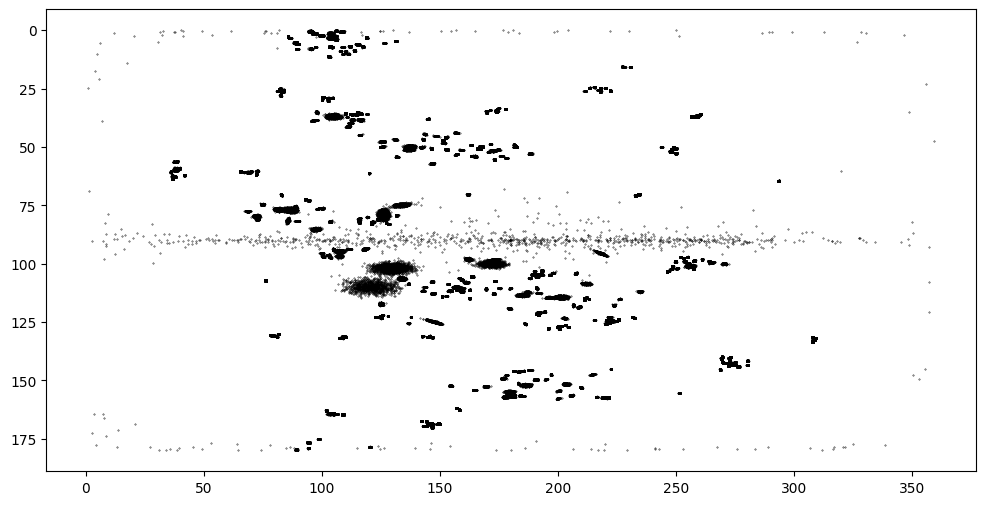

In [96]:
import pandas as pd

for i, direct in enumerate(["Front", "Back", "Left", "Right", "Top", "Bottom"]):
        # read the data from the .txt file into a dataframe
        stardata = pd.read_csv(datapath + f'/{direct}/Star Data.txt', delimiter=' ')  
        u = stardata["X"].to_numpy(); v = stardata["Y"].to_numpy()
        azimuth, theta = cube_to_equirect(direct, u, v)
        
        df = pd.DataFrame({"Equat": azimuth, "Polar": theta})
        
        stardata['X'] = df['Equat']
        stardata["Y"] = df["Polar"]
        stardata = stardata.rename(columns={"X": "Equat", "Y": "Polar"})
        if i == 0:
            all_stardata = stardata
        else:
            all_stardata = pd.concat([all_stardata, stardata]).reset_index(drop=True)
# with open(datapath + "/CONVERT Star Data.txt", "w") as file:
    
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(all_stardata["Equat"].to_numpy(), all_stardata["Polar"].to_numpy(), s=0.1, c='k');
ax.invert_yaxis();
        
